# Postprocessing and Dataset Maker (for aggregating SPEED results) (quick thing)
TODO :
1. postprocessing (make `postprocessing` class or sth)
    * clip/zero if too large
    * standardization
2. saving dataset_maker (make a h5 saver class or sth)
    * following should be saved : data, lfreq, hfreq, and ch_names and such remember
    *


In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd , numpy as np, mne, os
from glob import glob

### Path 설정
data_pd_dir = '../dataset_maker/tuh_preproc_related/'

### Preprocessing Parameter 설정
pretrain_overlap_removal_criteria = 'edf_overlap' #'subject_overlap'  # or 'edf_overlap' depending on the criteria

#pretrain_overlap_removal_criteria 옵션에 따라, df_pretrain (i.e. 전처리하는 dataframe)이 달라집니다.
if pretrain_overlap_removal_criteria == "subject_overlap" :
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_subs_only_in_main.csv')
elif pretrain_overlap_removal_criteria == "edf_overlap" :
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_main_only.csv')
elif pretrain_overlap_removal_criteria == "all" :
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_complete_distribution.csv')
else :
    raise ValueError("Proper overlap removal criteria not defined")




FileNotFoundError: [Errno 2] No such file or directory: '../dataset_maker/tuh_preproc_related/tuh_edf_main_only.csv'

#### **things that will be provided** to the class

1. `df_pretrain` : dataframe where the original data names are stored
    * must have `save_method` (same as used during SPEED preprocessing). Only implement for `tueg_fif_ours` for the time being
    * must have `filename` (to match the name, if `save_method` used was `tueg_fif_ours` during SPEED preprocessing)
    => these two will choose the "SPEED2DF mapper" function or sth (so that the SPEED's result (Path object) can be mapped to the row in df_pretrain)
2. `SPEED_output_path` : path of the `out` folder that holds the SPEED result
3. `h5_save_path`
4. `h5_save_format` : for now, just do "LaBraM"

In [2]:
import pandas as pd , numpy as np, mne, os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from typing import Optional, Union
from joblib import Parallel, delayed
import h5py

class BatchPostProcessor:
    def __init__(self, df_pretrain : pd.DataFrame, SPEED_saved_path : str,  h5_save_path : str,
                 SPEED_saved_method : str = 'tueg_fif_ours', h5_save_method : str = 'LaBraM',
                 postproc_setting : str = 'LaBraM', n_jobs : int =1):
        self.df_pretrain = df_pretrain
        self.SPEED_saved_path = SPEED_saved_path
        self.h5_save_path = h5_save_path
        self.SPEED_saved_method = SPEED_saved_method
        self.h5_save_method = h5_save_method
        self.postproc_setting = postproc_setting
        self.n_jobs = n_jobs

        #setup some stuff
        self.file_list = self.get_file_paths()
        self.file_list = self.file_list
        self.extreme_value_handle_params, self.normalize_params = self.get_postproc_settings()

    def process_file(self, file_path):
        processor = FilePostProcessingAndSaving(file_path, saved_method=self.SPEED_saved_method,
                                                extreme_value_handle_params=self.extreme_value_handle_params, normalize_params=self.normalize_params,
                                                h5_save_method=self.h5_save_method, h5_save_path = self.h5_save_path)
        #!#file_path, saved_method=self.SPEED_saved_method, params={}) #modify params ={} at the end as needed (kwargs)
        processor.load_file()
        processor.np_data, processor.ch_names = processor.load_npy() #by default loads in uV
        processor.postprocess()
        processor.save()

        #for checking in between
        # print("0", processor.np_data.shape, processor.np_data.mean(axis=1), processor.np_data.std(axis=1), processor.np_data.min(), processor.np_data.max())
    def run(self):
        Parallel(n_jobs=self.n_jobs)(
            delayed(self.process_file)(file_path) for file_path in self.file_list
        )


    ###=====METHODS FOR GETTING FIF file list (for creating self.file_list and passing to `run`)=====###
    def get_file_paths(self):
        if self.SPEED_saved_method == 'tueg_fif_ours':
            return self._get_file_paths_tueg_fif_ours()
        else:
            raise ValueError("save_method not recognized")

    def _get_file_paths_tueg_fif_ours(self):
        fif_paths = glob(os.path.join(self.SPEED_saved_path, '**/*.fif'),recursive=True)
        return fif_paths

    ###=====METHODS FOR SETTING UP POSTPROCESSING SETTINGS=====###
    def get_postproc_settings(self):
        if self.postproc_setting == 'LaBraM':
            extreme_value_handle_params =  {'method' : "absolute_deviation_clip", 'clip_values' : 800}  #{'method' : None}
            normalize_params = {'method' : None} #{'method' : 'ch_zscore'}
            return extreme_value_handle_params, normalize_params
        else:
            raise ValueError("postproc_setting not recognized")

    ###=====METHODS FOR GETTING LABELS (NOT USED FOR NOW, FOR ANGELA)=====###
    def get_row_from_SPEED(self, fif_path)  :
        #! this was added for future compatibility (df_pretrain is not needed tbh, but for the future when labeled data is needed, from which label should be brought from df_pretrain)
        if self.save_method == 'tueg_fif_ours':
            return self._tueg_fif_ours_mapper(fif_path)
        else:
            raise ValueError("save_method not recognized")

    def _tueg_fif_ours_mapper(self, fif_path):
        r"""
        maps the fif file to the pretrain dataframe assuming "tueg_fif_ours" method was used for `save_method` in SPEED yaml
        """
        #get the subject id
        folder_name = fif_path.split('/')[-2]
        window_dix = fif_path.split('/')[-1].split('.')[0]

        #get the pretrain dataframe row
        pretrain_row = self.df_pretrain[self.df_pretrain['filename'] == folder_name + '.edf']
        return pretrain_row

    ###=====METHODS FOR AGGREGATING ALL RUNS AND SAVING THEM=====###
    def aggregate_all_runs(self):
        if self.h5_save_method == 'LaBraM':
            self._save_all_runs_LaBraM()
        else :
            raise ValueError("h5_save_method not recognized")

    def _save_all_runs_LaBraM(self, fp32 : bool = True):
        ##getting the path
        final_save_h5_path = Path(os.path.join(self.h5_save_path, '..'))
        final_save_h5_dataset = h5Dataset(final_save_h5_path, 'FINAL_ALL_RUNS')

        ##saving to new_path and adding attributes : lfreq, hfreq, rsfreq, self.ch_names
        h5_files_list = glob(os.path.join(self.h5_save_path, '**/*.h5'),recursive=True)
        h5_files2_dataset_namer = lambda path : "-".join(path.split('/')[-2:]).split('.')[0]
        print(Path(self.h5_save_path))
        for SPEED_saved_h5_file in h5_files_list:
            with h5py.File(SPEED_saved_h5_file, 'r') as single_file_dataset:
                single_file_dataset_name = h5_files2_dataset_namer(SPEED_saved_h5_file)
                print(f"processing {single_file_dataset_name}")
                data, attrs = single_file_dataset['data'][:], dict(single_file_dataset.attrs)
                data = data.astype(np.float32) if fp32 else data
                chOrder_renamed = [ch.upper() for ch in attrs['chOrder']]
                chunk_size = (data.shape[0]//2, attrs['rsFreq'])  #ex : (30, 200) (30 channels, 200 samples)

                #creating and saving the dataset as a group to the final h5 file
                grp = final_save_h5_dataset.addGroup(grpName = single_file_dataset_name)
                single_h5_dataset = final_save_h5_dataset.addDataset(grp, dsName = 'eeg', arr = data, chunks = chunk_size)

                #dataset attributes
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'lFreq', attrs['lFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'hFreq', attrs['hFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'rsFreq', attrs['rsFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'chOrder', chOrder_renamed)
                attrs_not_in_above = {k : v for k,v in attrs.items() if k not in ['lFreq', 'hFreq', 'rsFreq', 'chOrder']}
                for attr_name, attr_value in attrs_not_in_above.items():
                    final_save_h5_dataset.addAttributes(single_h5_dataset, attr_name, attr_value)
        final_save_h5_dataset.save()

class FilePostProcessingAndSaving:
    def __init__(self, fif_path, saved_method : str,
                 extreme_value_handle_params : dict, normalize_params : dict,
                 h5_save_method : str = 'LaBraM', h5_save_path : str = None):
        self.fif_path = fif_path
        self.saved_method = saved_method
        self.extreme_value_handle_params = extreme_value_handle_params
        self.normalize_params = normalize_params
        self.h5_save_method = h5_save_method
        self.h5_save_path = h5_save_path

    ###=====METHODS FOR LOADING FILE/NPY=====###
    def load_file(self):
        if self.saved_method == 'tueg_fif_ours':
            self.raw = self._load_file_tueg_fif_ours()
        else:
            raise ValueError("save_method not recognized")

    def _load_file_tueg_fif_ours(self):
        return mne.io.read_raw_fif(self.fif_path, preload=True)

    def load_npy(self, unit : str = 'uV'):
        return self.raw.get_data(units=unit), self.raw.info['ch_names']

    ###=====METHODS FOR POSTPROCESSING=====###
    def postprocess(self):
        self.handle_extreme_values(**self.extreme_value_handle_params) ##ex : {'clip_method' : 'absolute_deviation_clip', 'clip_values' : 3}
        self.normalize_data(**self.normalize_params) ##ex : {'method' : 'ch_zscore'}

    def handle_extreme_values(self, method : str = None, clip_values = None):
        if method is None :
            return
        elif method == "absolute_deviation_clip" :
            self.np_data = np.clip(self.np_data, -clip_values, clip_values) #! must be tested
        elif method == "absolute_deviation_replace" :
            self.np_data = np.where(np.abs(self.np_data) > clip_values, np.nan, self.np_data) #! must be tested
        elif method == "zscore_clip" :
            raise NotImplementedError("Not implemented yet")
        elif method == "zscore_replace" :
            raise NotImplementedError("Not implemented yet")
        elif method == "minmax_clip" :
            #! TODO : for Angela : might be better if you clip_values as a dict that specifiecs the percentiles and what to replace with and such...
            raise NotImplementedError("Not implemented yet")
        elif method == "minmax_replace" :
            raise NotImplementedError("Not implemented yet")
        else :
            raise ValueError(f"{method} not recognized")

    def normalize_data(self, method : str = None):
        if method is None :
            return
        elif method == "demean" :
            self.np_data = self.np_data - np.mean(self.np_data, axis=1, keepdims=True)
        elif method == 'ch_zscore' :
            self.np_data = (self.np_data - np.mean(self.np_data, axis=1, keepdims=True)) / np.std(self.np_data, axis=1, keepdims=True)
        elif method == 'ch_minmax' :
            raise NotImplementedError("Not implemented yet")
        elif method == 'laura' :
            #! TODO : Angela, implement this!
            raise NotImplementedError("Not implemented yet")

    ###=====METHODS FOR SAVING=====###
    def save(self):
        if (self.h5_save_method == 'LaBraM') and (self.saved_method == 'tueg_fif_ours'):
            self._save_LaBraM()
        else:
            raise ValueError("h5_save_method not recognized")

    def _save_LaBraM(self):
        ##getting the path
        convert_to_h5 = lambda path: "/".join(path.split('/')[-2:]).replace('.fif', '.h5')
        new_path = os.path.join(self.h5_save_path, convert_to_h5(self.fif_path))

        os.makedirs(os.path.dirname(new_path), exist_ok=True)

        ##saving to new_path and adding attributes : lfreq, hfreq, rsfreq, self.ch_names
        with h5py.File(new_path, 'w') as f:
                f.create_dataset('data', data=self.np_data)
                f.attrs['lFreq'] = self.raw.info['lowpass']
                f.attrs['hFreq'] = self.raw.info['highpass']
                f.attrs['rsFreq'] = self.raw.info['sfreq']
                f.attrs['chOrder'] = self.ch_names
                f.attrs['time_idx'] = eval(self.raw.info['description'])['time_idx']

###HDF5 AGGREGATE SAVER
#do below (look at make_h5dataset_for_pretrain.py)

import h5py
import numpy as np
from pathlib import Path

class h5Dataset:
    def __init__(self, path:Path, name:str) -> None:
        self.__name = name
        self.__f = h5py.File(path / f'{name}.hdf5', 'a')

    def addGroup(self, grpName:str):
        return self.__f.create_group(grpName)

    def addDataset(self, grp:h5py.Group, dsName:str, arr:np.array, chunks:tuple):
        return grp.create_dataset(dsName, data=arr, chunks=chunks)

    def addAttributes(self, src:'h5py.Dataset|h5py.Group', attrName:str, attrValue):
        src.attrs[f'{attrName}'] = attrValue

    def save(self):
        self.__f.close()

    @property
    def name(self):
        return self.__name


# current visualization

In [10]:
import os
import pandas as pd

def create_dataset(root_dir):
    data = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            full_path = os.path.join(dirpath, filename)
            data.append([filename,full_path])
    df = pd.DataFrame(data, columns=["filename", "full_path"])
    return df

root_directory = "/content/drive/MyDrive/LiNC Lab/physionetMI/raw/S001"
df_pretrain=create_dataset(root_directory)
#arguments
h5_file_path = "/global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/FINAL_ALL_RUNS.hdf5"
save_method = "LaBraM"
dataset = "TUEG"
save_method = 'tueg_fif_ours' #same as SPEED's yaml file thing (so the mapping is same)
base_path = "/content/drive/MyDrive/LiNC Lab/physionetMI"
edf_dir = "/content/drive/MyDrive/LiNC Lab/physionetMI/raw/S001"

h5_save_path = os.path.join(base_path, "postprocessing_SPEED")
h5_save_format = "LaBraM" #for now, just use this
#get the fif files
fif_paths = glob(os.path.join(base_path, '**/*.fif'),recursive=True)

In [12]:
SPEED_output_path = "/content/drive/MyDrive/LiNC Lab/physionetMI"
processor = BatchPostProcessor(df_pretrain, SPEED_output_path, h5_save_path, save_method, h5_save_format, n_jobs=1)
processor.run()
processor.aggregate_all_runs()


os.listdir(processor.h5_save_path)
processor.h5_save_path

Opening raw data file /content/drive/MyDrive/LiNC Lab/physionetMI/S001R04/1_eeg.fif...
    Range : 0 ... 12999 =      0.000 ...    64.995 secs
Ready.
Reading 0 ... 12999  =      0.000 ...    64.995 secs...
Opening raw data file /content/drive/MyDrive/LiNC Lab/physionetMI/S001R04/0_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /content/drive/MyDrive/LiNC Lab/physionetMI/S001R14/1_eeg.fif...
    Range : 0 ... 12999 =      0.000 ...    64.995 secs
Ready.
Reading 0 ... 12999  =      0.000 ...    64.995 secs...
Opening raw data file /content/drive/MyDrive/LiNC Lab/physionetMI/S001R14/0_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /content/drive/MyDrive/LiNC Lab/physionetMI/S001R12/1_eeg.fif...
    Range : 0 ... 12999 =      0.000 ...    64.995 secs
Ready.
Reading 0 ... 12999  =    

'/content/drive/MyDrive/LiNC Lab/physionetMI/postprocessing_SPEED'

In [31]:
import os
import mne
import h5py
import numpy as np
import pandas as pd
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import re
h5_file_path="/content/drive/MyDrive/LiNC Lab/physionetMI/FINAL_ALL_RUNS.hdf5"
# =====================================================================
# Step 1: Define Channel Name Normalization Function
# =====================================================================
def normalize_channel_name(ch_name):
    """
    Normalizes channel names by extracting the core identifier.
    Examples:
        "EEG F1-REF" -> "F1"
        "EEG F1-LE" -> "F1"
        "F1" -> "F1"
        "C3'" -> "C3"
    """
    # Remove EEG prefix and any suffixes like -REF, -LE, -RE, -A1, etc.
    # Extract the main channel identifier (e.g., "F1", "C3")
    # This regex captures letters followed by numbers, ignoring any suffixes
    name = ch_name.replace('.', '')
    name = name.upper()
    return name
    # match = re.match(r"(?:EEG\s*)?([A-Za-z]+[0-9]+)", ch_name)
    # if match:
    #     return match.group(1).upper()
    # else:
    #     # If it doesn't match, return the original name in uppercase
    #     return ch_name.upper()

# =====================================================================
# Step 2: Open HDF5 File and Gather Dataset Names
# =====================================================================
# Open the HDF5 file
h5_file = h5py.File(h5_file_path, 'r')

# Get the list of dataset names in the HDF5 file
h5_dataset_names = list(h5_file.keys())

# =====================================================================
# Step 3: Map EDF Base Names to HDF5 Datasets
# =====================================================================
def extract_edf_base_name(dataset_name):
    """
    Extracts the EDF base name from the H5 dataset name.
    Example: 'aaaaaaaq_s006_t000-10_eeg' -> 'aaaaaaaq_s006_t000'
    """
    if '_eeg' in dataset_name:
        return dataset_name.rsplit('-', 1)[0]
    return None

# Map EDF base names to corresponding H5 datasets
edf_to_h5_datasets = defaultdict(list)
for dataset_name in h5_dataset_names:
    edf_base_name = extract_edf_base_name(dataset_name)
    if edf_base_name:
        edf_to_h5_datasets[edf_base_name].append(dataset_name)

# =====================================================================
# Step 4: Gather EDF Files
# =====================================================================
# Gather list of EDF files
edf_files = glob(os.path.join(edf_dir, '**/*.edf'), recursive=True)

# Map EDF base names to file paths
edf_base_to_path = {}
for edf in edf_files:
    edf_basename = os.path.basename(edf).replace('.edf', '')
    edf_base_to_path[edf_basename] = edf

# =====================================================================
# Step 5: Analyze and Collect Data with Normalized Channel Names
# =====================================================================
data_records = []
for edf_base_name, edf_path in edf_base_to_path.items():
    h5_datasets = edf_to_h5_datasets.get(edf_base_name, [])
    if not h5_datasets:
        print(f"No corresponding H5 datasets found for EDF: {edf_base_name}")
        continue  # Skip if no corresponding HDF5 datasets

    # Load the raw EDF data
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    except Exception as e:
        print(f"Error loading EDF file {edf_path}: {e}")
        continue

    edf_channels = raw.info['ch_names']
    edf_duration = raw.times[-1]

    # Normalize EDF channel names
    normalized_edf_channels = set(normalize_channel_name(ch) for ch in edf_channels)

    # Initialize variables to collect HDF5 data info
    h5_channels_set = set()
    h5_time_windows = []
    total_coverage = 0
    window_boundaries = []
    for h5_dataset_name in h5_datasets:
        # Access the dataset in the HDF5 file
        try:
            dataset = h5_file[h5_dataset_name]['eeg']
        except KeyError:
            print(f"Dataset 'eeg' not found in group '{h5_dataset_name}'")
            continue

        data = dataset[:]
        attrs = dict(dataset.attrs)

        # Decode and normalize channel names
        chOrder = attrs.get('chOrder', [])
        channels_in_h5 = [normalize_channel_name(ch.decode('utf-8') if isinstance(ch, bytes) else ch) for ch in chOrder]
        h5_channels_set.update(channels_in_h5)

        # Get time index
        time_idx = attrs.get('time_idx', (0, data.shape[1] / attrs.get('rsFreq', 1)))
        h5_time_windows.append(time_idx)
        total_coverage += time_idx[1] - time_idx[0]

        # Collect window boundaries for plotting vertical lines
        window_boundaries.append(time_idx[0])
        window_boundaries.append(time_idx[1])

    # Identify missing channels and duration
    missing_channels = normalized_edf_channels - h5_channels_set
    missing_duration = edf_duration - total_coverage

    # Record the information
    data_record = {
        'edf_base_name': edf_base_name,
        'edf_path': edf_path,
        'edf_channels': edf_channels,
        'normalized_edf_channels': list(normalized_edf_channels),
        'edf_duration': edf_duration,
        'h5_datasets': h5_datasets,
        'h5_channels': list(h5_channels_set),
        'missing_channels': list(missing_channels),
        'h5_time_windows': h5_time_windows,
        'window_boundaries': window_boundaries,  # Added for vertical lines
        'missing_duration': missing_duration,
    }
    data_records.append(data_record)

# Create DataFrame
df = pd.DataFrame(data_records)

# Optionally, save the DataFrame for later use
# df.to_pickle('data_records.pkl')

In [32]:
def plot_edf_and_h5(edf_base_name, df, h5_file, time_range=None, channels=None):
    """
    Plots raw EDF data and H5 data side by side using Matplotlib with channel information.
    Args:
        edf_base_name (str): Base name of the EDF file
        df (pd.DataFrame): DataFrame containing the mapped data records
        h5_file (h5py.File): Opened HDF5 file object
        time_range (tuple, optional): Time range to plot (start_time, end_time) in seconds
        channels (list, optional): List of channel names to plot
    """
    # Find the record for the specified EDF base name
    record = df[df['edf_base_name'] == edf_base_name]
    if record.empty:
        print(f"No data found for EDF base name: {edf_base_name}")
        return
    record = record.iloc[0]
    edf_path = record['edf_path']
    h5_datasets = record['h5_datasets']
    window_boundaries = record.get('window_boundaries', [])

    # Read raw EDF data
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    except Exception as e:
        print(f"Error loading EDF file {edf_path}: {e}")
        return

    # Handle FIFF units (107 is FIFF_UNIT_V which represents Volts)
    def get_scaling_factor(unit):
        if unit == 'V' or unit == '107 (FIFF_UNIT_V)':
            return 1e6  # Convert V to µV
        elif unit == 'mV':
            return 1e3  # Convert mV to µV
        elif unit == 'µV' or unit == 'uV':
            return 1.0  # Already in µV
        else:
            return 1e6  # Default to assuming V if unknown

    # Check units and scaling from EDF header
    chs = raw.info['chs']
    scaling_factors = [get_scaling_factor(ch.get('unit', None)) for ch in chs]
    scaling_factors = np.array(scaling_factors)[:, np.newaxis]

    # Normalize EDF channel names
    edf_channels = raw.info['ch_names']
    normalized_edf_channels = [normalize_channel_name(ch) for ch in edf_channels]

    # Set default channels to plot if not specified
    if channels is None:
        channels = normalized_edf_channels
    else:
        channels = [normalize_channel_name(ch) for ch in channels]

    # Create mapping between normalized names and original names
    channel_mapping = dict(zip(normalized_edf_channels, edf_channels))

    # Find which requested channels are actually available
    available_channels = []
    available_original_channels = []
    for ch in channels:
        if ch in normalized_edf_channels:
            available_channels.append(ch)
            available_original_channels.append(channel_mapping[ch])

    if not available_channels:
        print("No requested channels found in the data!")
        return

    # Report unavailable channels
    unavailable = set(channels) - set(available_channels)
    if unavailable:
        print(f"Warning: The following channels were not found in the data: {sorted(unavailable)}")

    # Create a fixed color mapping for all possible channels
    all_possible_channels = list(set(channels))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if len(all_possible_channels) > len(colors):
        colors = colors * (len(all_possible_channels) // len(colors) + 1)
    channel_colors = dict(zip(all_possible_channels, colors[:len(all_possible_channels)]))

    # Pick channels
    raw.pick_channels(available_original_channels)

    # Get raw data and apply scaling
    raw_data, raw_times = raw[:]
    raw_data = raw_data * scaling_factors[:len(raw_data)]

    # Apply time range to raw data if specified
    if time_range:
        raw_mask = (raw_times >= time_range[0]) & (raw_times <= time_range[1])
        raw_data = raw_data[:, raw_mask]
        raw_times = raw_times[raw_mask]

    # Initialize H5 data structures
    h5_data_segments = []
    h5_times_segments = []
    h5_channels_per_window = []
    all_h5_channels = set()

    # Collect H5 data segments and channel information
    for h5_dataset_name in h5_datasets:
        try:
            dataset = h5_file[h5_dataset_name]['eeg']
            data = dataset[:]
            attrs = dict(dataset.attrs)

            # Get channel information
            chOrder = attrs.get('chOrder', [])
            channels_in_h5 = [normalize_channel_name(ch.decode('utf-8') if isinstance(ch, bytes) else ch)
                            for ch in chOrder]

            # Update the set of all channels across all windows
            all_h5_channels.update(channels_in_h5)

            # Get time information
            sfreq = attrs.get('rsFreq', raw.info['sfreq'])
            time_idx = attrs.get('time_idx', (0, data.shape[1] / sfreq))
            t_start, t_end = time_idx

            if time_range and (t_end < time_range[0] or t_start > time_range[1]):
                continue

            t = np.linspace(t_start, t_end, data.shape[1], endpoint=False)
            h5_data_segments.append((data, channels_in_h5, t))
            h5_times_segments.append((t_start, t_end))
            h5_channels_per_window.append(set(channels_in_h5))

        except KeyError:
            print(f"Dataset 'eeg' not found in group '{h5_dataset_name}'")
            continue

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1.2]})

    # Plot Raw EDF Data
    for idx, ch in enumerate(available_channels):
        if ch in channel_colors:
            axs[0].plot(raw_times, raw_data[idx], label=ch, color=channel_colors[ch], alpha=0.7)
        else:
            axs[0].plot(raw_times, raw_data[idx], label=ch, alpha=0.7)

    axs[0].set_title(f'Raw EDF Data: {edf_base_name}')
    axs[0].set_ylabel('Amplitude (µV)')
    axs[0].legend(loc='upper right', ncol=5, fontsize='small')
    axs[0].grid(True)

    # Plot H5 Data with gaps and channel information
    if h5_times_segments:
        h5_times_segments.sort(key=lambda x: x[0])

        # Plot data gaps
        for i in range(len(h5_times_segments) - 1):
            current_end = h5_times_segments[i][1]
            next_start = h5_times_segments[i + 1][0]
            if next_start > current_end:
                if time_range:
                    gap_start = max(current_end, time_range[0])
                    gap_end = min(next_start, time_range[1])
                    if gap_start < gap_end:
                        axs[1].axvspan(gap_start, gap_end, color='lightgray', alpha=0.3)
                else:
                    axs[1].axvspan(current_end, next_start, color='lightgray', alpha=0.3)

        if time_range:
            if h5_times_segments[0][0] > time_range[0]:
                axs[1].axvspan(time_range[0], h5_times_segments[0][0], color='lightgray', alpha=0.3)
            if h5_times_segments[-1][1] < time_range[1]:
                axs[1].axvspan(h5_times_segments[-1][1], time_range[1], color='lightgray', alpha=0.3)

    # Plot H5 data segments
    plotted_channels = set()
    for idx, (data, channels_in_h5, times) in enumerate(h5_data_segments):
        for ch in available_channels:
            if ch in channels_in_h5:
                ch_idx = channels_in_h5.index(ch)
                if time_range:
                    mask = (times >= time_range[0]) & (times <= time_range[1])
                    if np.any(mask):
                        label = ch if ch not in plotted_channels else None
                        if ch in channel_colors:
                            axs[1].plot(times[mask], data[ch_idx, mask],
                                      color=channel_colors[ch], label=label)
                        else:
                            axs[1].plot(times[mask], data[ch_idx, mask], label=label)
                        plotted_channels.add(ch)
                else:
                    label = ch if ch not in plotted_channels else None
                    if ch in channel_colors:
                        axs[1].plot(times, data[ch_idx], color=channel_colors[ch], label=label)
                    else:
                        axs[1].plot(times, data[ch_idx], label=label)
                    plotted_channels.add(ch)

        # Add channel information for each window
        window_center = (times[0] + times[-1]) / 2
        missing_channels = all_h5_channels - set(channels_in_h5)
        total_channels = len(channels_in_h5)

        if missing_channels:
            missing_text = f"Total: {total_channels}\nMissing: {len(missing_channels)}\n({', '.join(sorted(missing_channels))})"
        else:
            missing_text = f"Total channels: {total_channels}"

        if time_range is None or (times[0] <= time_range[1] and times[-1] >= time_range[0]):
            axs[1].text(window_center, axs[1].get_ylim()[1], missing_text,
                       horizontalalignment='center', verticalalignment='bottom',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Add "No Data" to legend if there are gaps
    if h5_times_segments and len(h5_times_segments) > 1:
        axs[1].axvspan(0, 0, color='lightgray', alpha=0.3, label='No Data')

    # Add window boundaries
    for boundary in window_boundaries:
        if time_range and (boundary < time_range[0] or boundary > time_range[1]):
            continue
        axs[0].axvline(x=boundary, color='red', linestyle='--', linewidth=1)
        axs[1].axvline(x=boundary, color='red', linestyle='--', linewidth=1,
                      label='Window Boundary' if boundary == window_boundaries[0] else None)

    # Final formatting
    axs[1].set_title(f'H5 Data: {edf_base_name}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude (µV)')
    axs[1].legend(loc='upper right', ncol=5, fontsize='small')
    axs[1].grid(True)

    if time_range:
        for ax in axs:
            ax.set_xlim(time_range)

    plt.tight_layout()
    plt.show()

In [16]:
len(channels_to_plot)

64

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


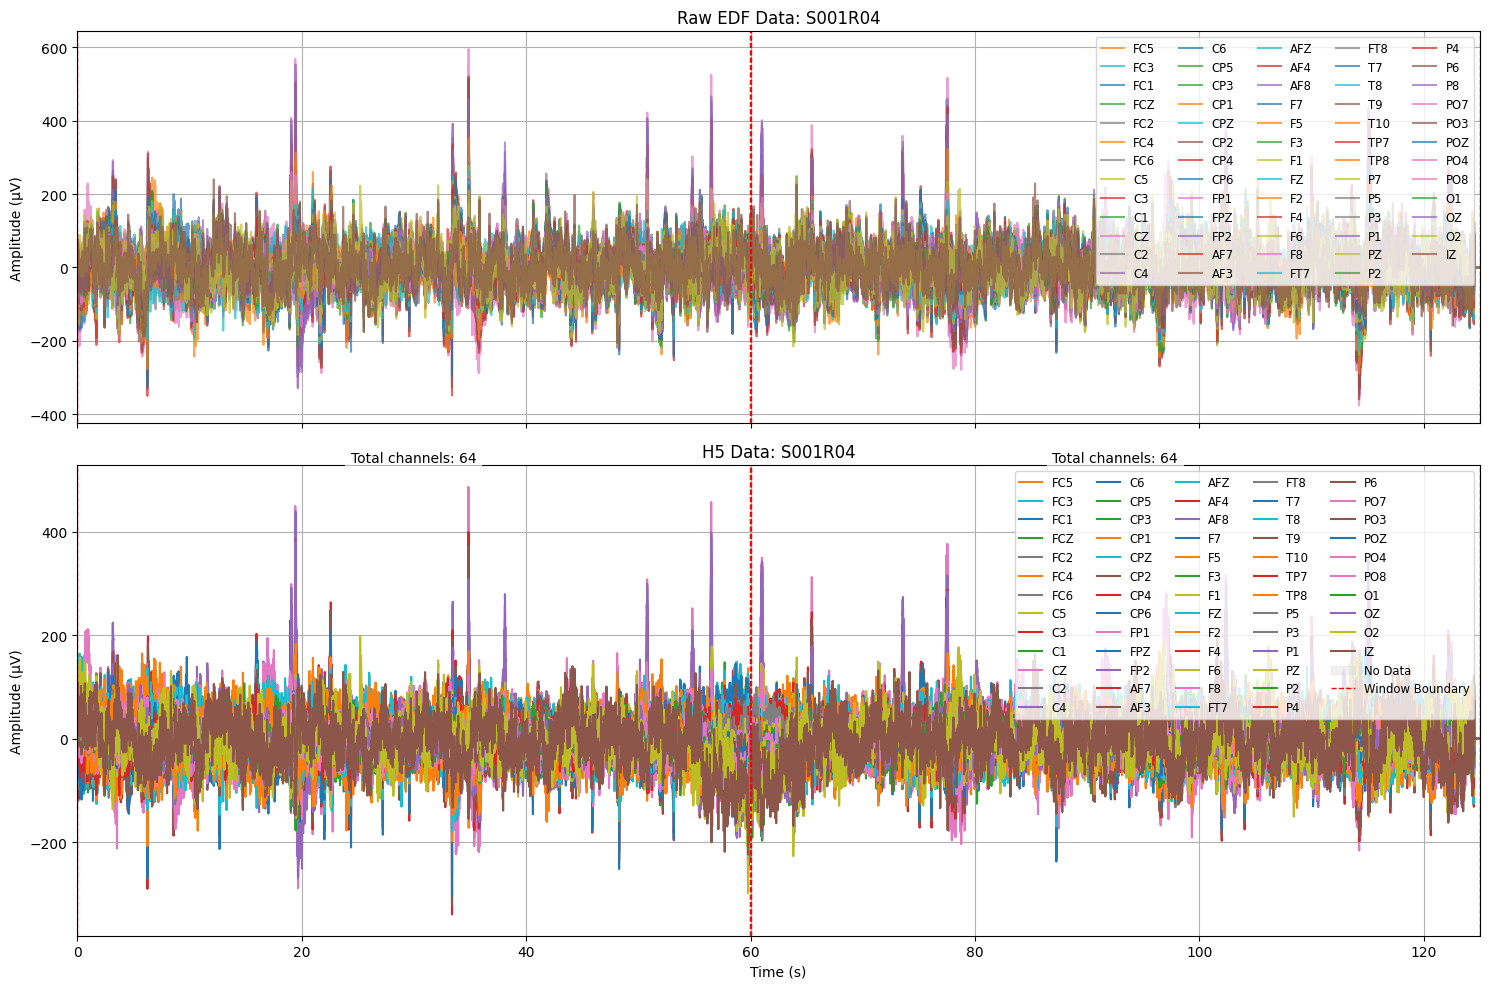

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


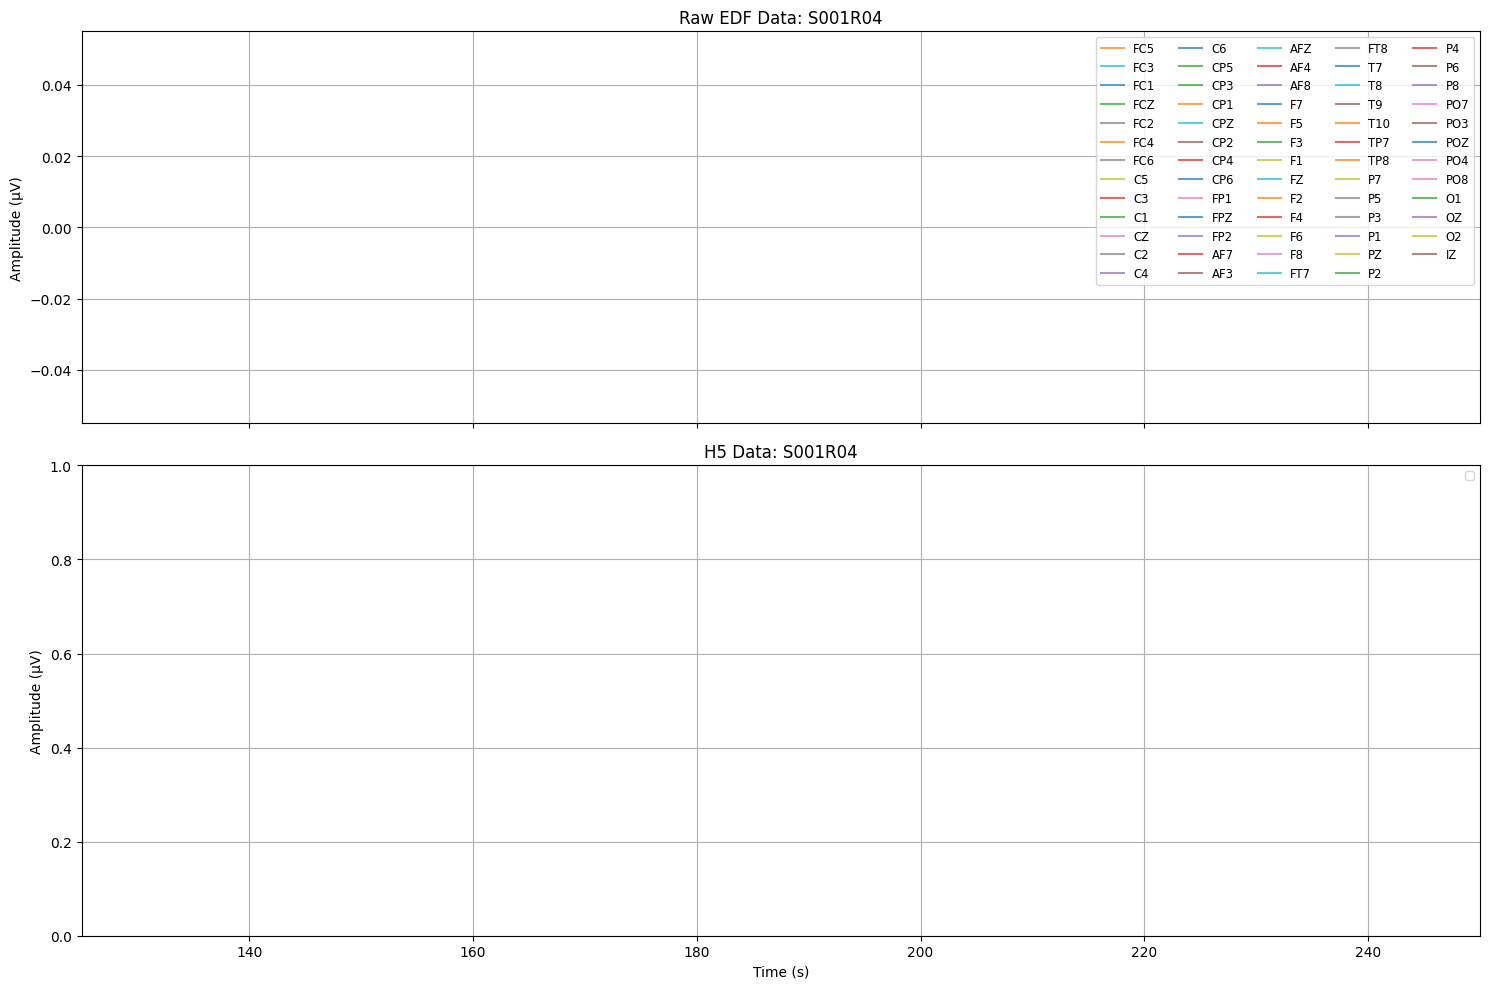

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


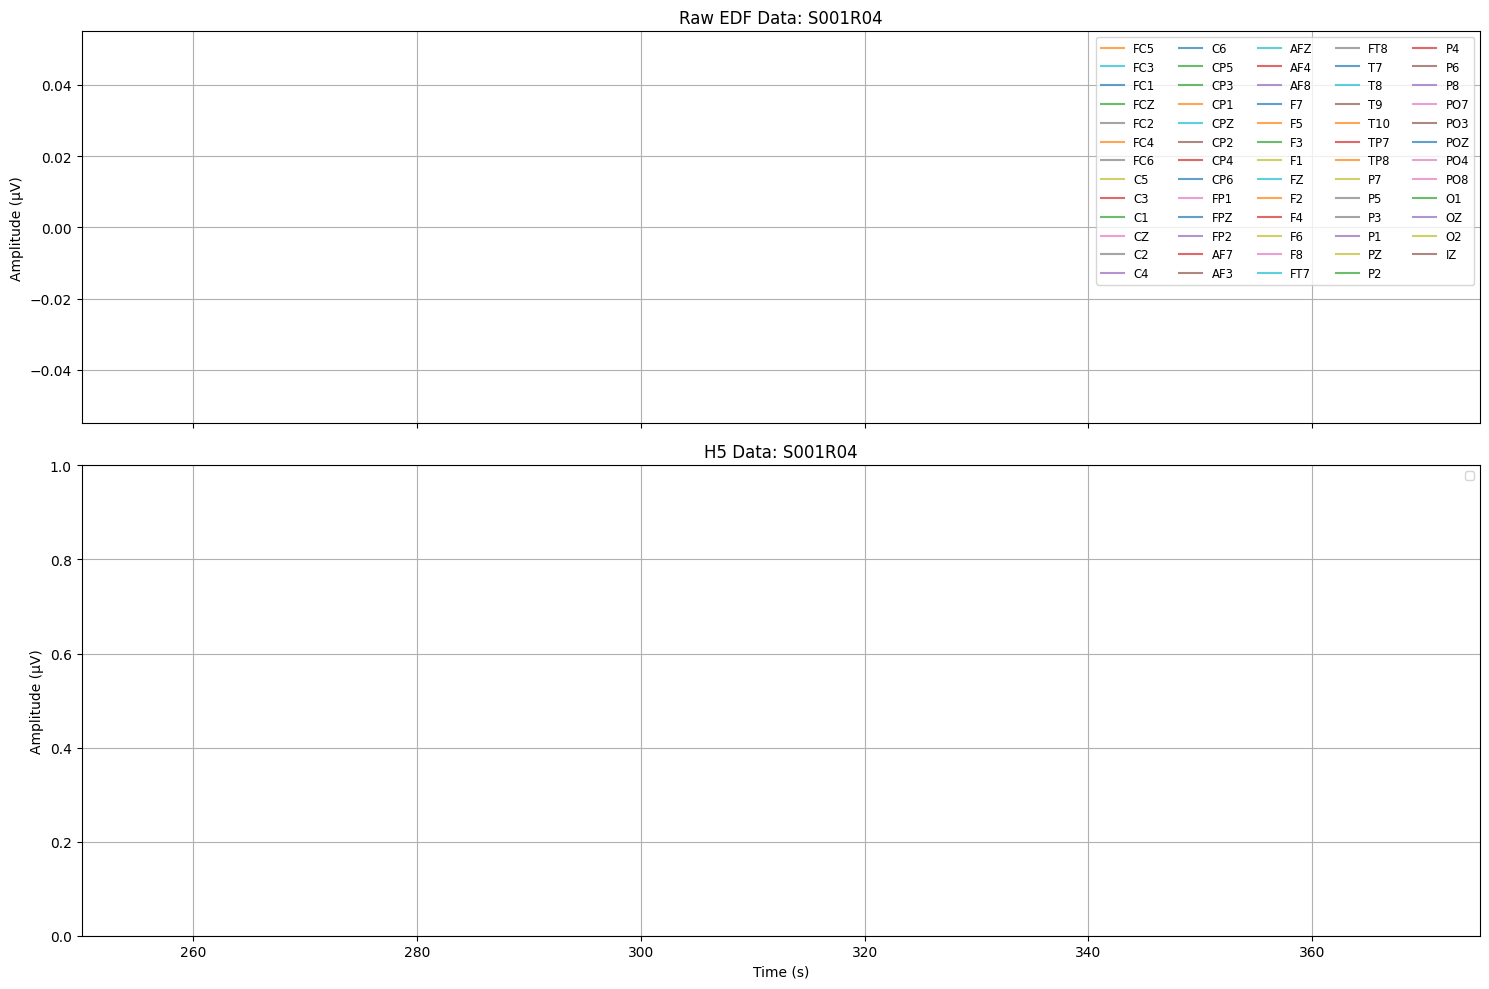

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


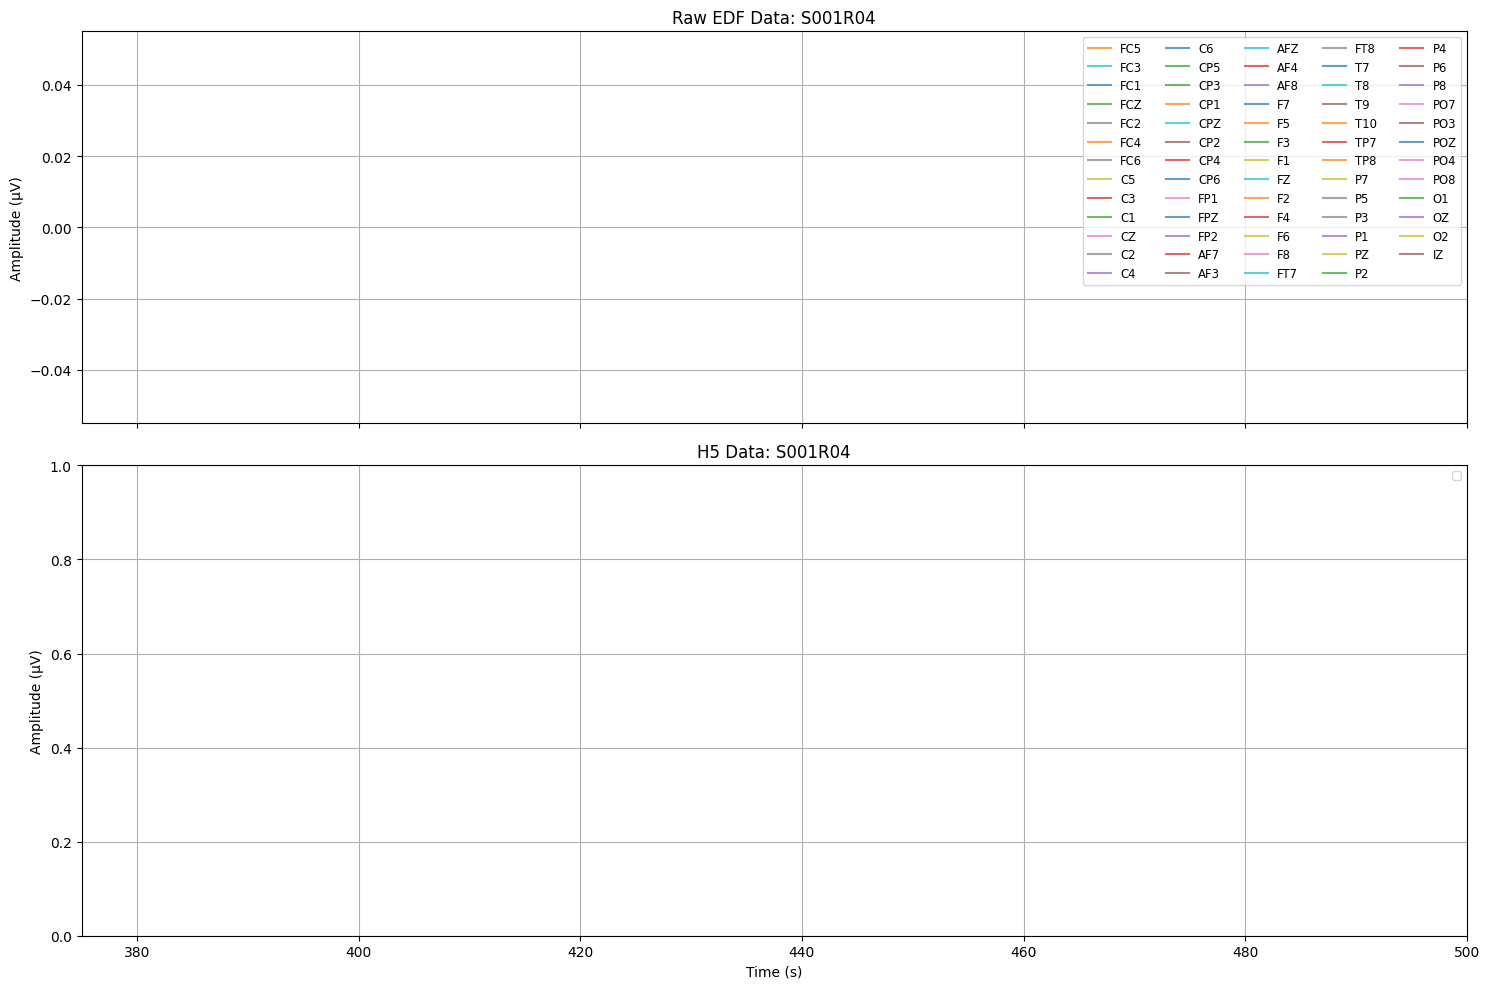

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


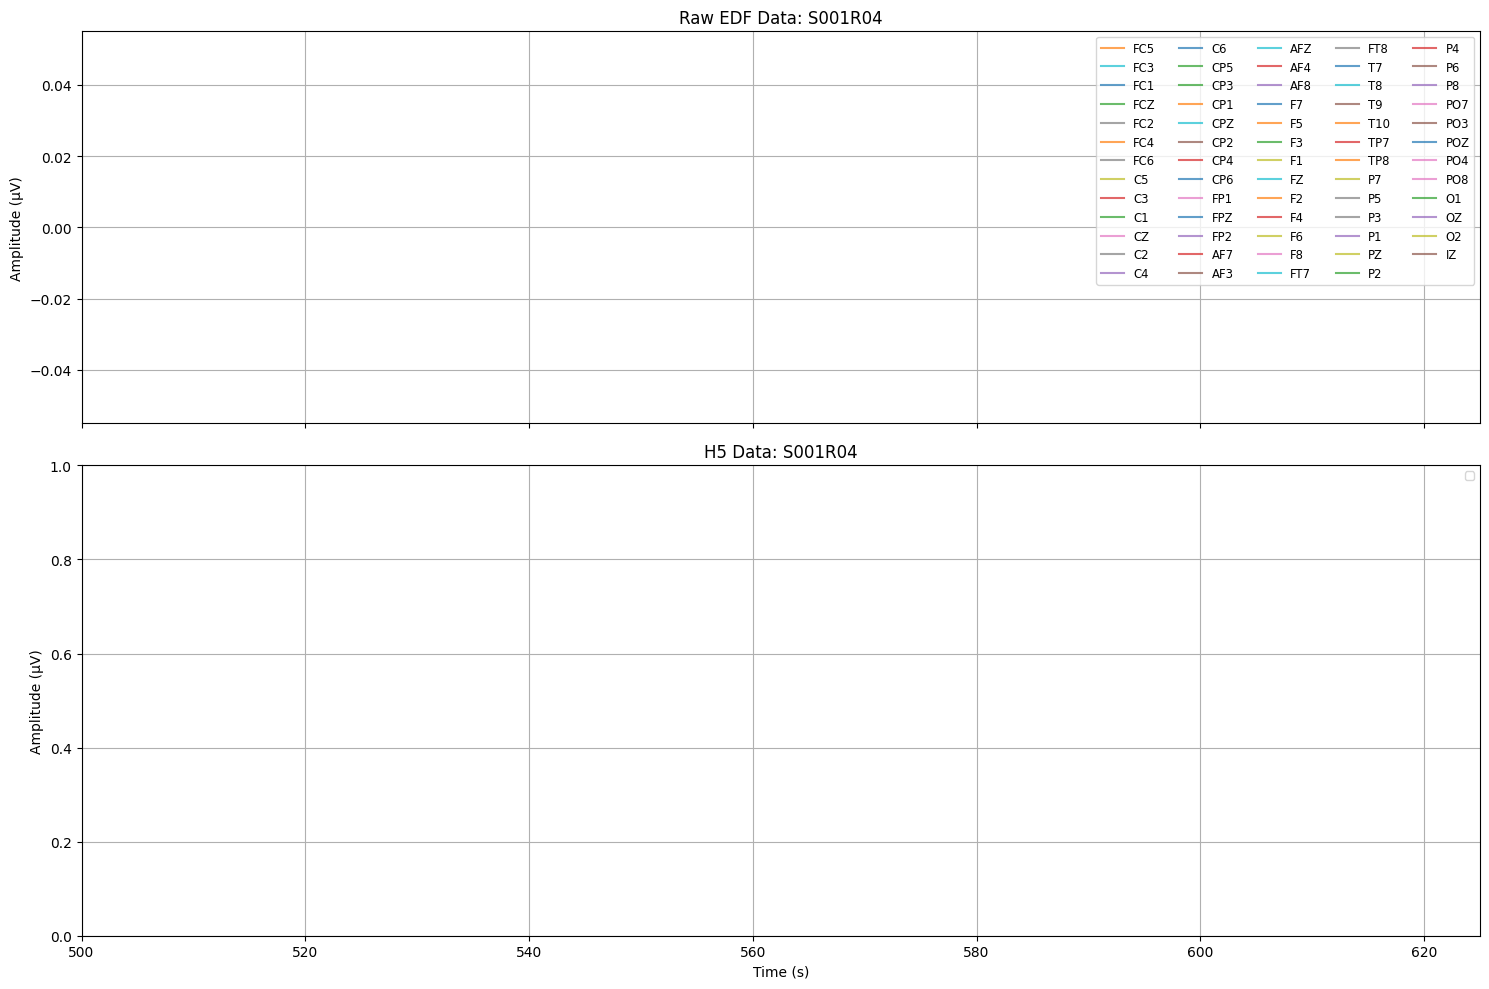

In [33]:
# Example: Plot for a specific EDF base name
edf_base_name_to_plot = 'S001R04'  # Replace with your target EDF base name
# channels_to_plot = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T7', 'C3', 'CZ', 'C4',
#                    'T8', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']  # Specify channels to plot
channels_to_plot = ['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1',
       'CZ', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4',
       'CP6', 'FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AFZ', 'AF4', 'AF8',
       'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8',
       'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1',
       'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POZ', 'PO4', 'PO8',
       'O1', 'OZ', 'O2', 'IZ']

time_steps = 125
end = 600

for i in range(0, end, time_steps):
    time_range_to_plot = (i, i + time_steps)  # Plot the first 60 seconds
    plot_edf_and_h5(edf_base_name=edf_base_name_to_plot,
                   df=df,
                   h5_file=h5_file,
                   time_range=time_range_to_plot,
                   channels=channels_to_plot)

In [28]:
def plot_psd_comparison(edf_path, h5_file, h5_datasets, sfreq=250, fmin=0, fmax=100):
    """
    Plots Power Spectral Density (PSD) for both raw EDF data and H5 windows.

    Args:
        edf_path (str): Path to the EDF file
        h5_file (h5py.File): Opened HDF5 file
        h5_datasets (list): List of H5 dataset names
        sfreq (float): Sampling frequency in Hz
        fmin (float): Minimum frequency to plot
        fmax (float): Maximum frequency to plot
    """
    import mne
    import numpy as np
    from scipy import signal
    import matplotlib.pyplot as plt

    # Read raw EDF data
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    # Function to compute PSD using Welch's method
    def compute_psd(data, fs):
        # Use Welch's method with 4-second windows (with 50% overlap)
        window_size = 4 * fs
        freqs, psd = signal.welch(data, fs=fs, nperseg=window_size,
                                noverlap=window_size//2, detrend='constant')
        mask = (freqs >= fmin) & (freqs <= fmax)
        return freqs[mask], psd[:, mask]

    # Compute PSD for raw EDF data
    raw_data = raw.get_data()
    raw_freqs, raw_psd = compute_psd(raw_data, raw.info['sfreq'])

    # Get channel names
    ch_names = raw.ch_names

    # Create figure
    n_channels = len(ch_names)
    fig, axs = plt.subplots(n_channels, 2, figsize=(15, 3*n_channels))
    fig.suptitle('Power Spectral Density Comparison\nLeft: Full Signal, Right: H5 Windows', fontsize=16)

    # Plot raw data PSDs
    for idx, ch_name in enumerate(ch_names):
        # Plot raw data PSD
        axs[idx, 0].semilogy(raw_freqs, raw_psd[idx], label='Raw EDF')
        axs[idx, 0].set_title(f'Channel: {ch_name} (Raw)')
        axs[idx, 0].set_xlabel('Frequency (Hz)')
        axs[idx, 0].set_ylabel('Power Spectral Density')
        axs[idx, 0].grid(True)

        # Initialize the right subplot
        axs[idx, 1].set_title(f'Channel: {ch_name} (H5 Windows)')
        axs[idx, 1].set_xlabel('Frequency (Hz)')
        axs[idx, 1].set_ylabel('Power Spectral Density')
        axs[idx, 1].grid(True)

    # Process each H5 dataset and plot their PSDs
    colors = plt.cm.rainbow(np.linspace(0, 1, len(h5_datasets)))

    for dataset_name, color in zip(h5_datasets, colors):
        try:
            dataset = h5_file[dataset_name]['eeg']
            data = dataset[:]
            attrs = dict(dataset.attrs)

            # Get channel information
            chOrder = attrs.get('chOrder', [])
            channels_in_h5 = [ch.decode('utf-8') if isinstance(ch, bytes) else ch for ch in chOrder]

            # Compute PSD for this window
            h5_freqs, h5_psd = compute_psd(data, sfreq)

            # Plot for each channel if present in this window
            for ch_idx, ch_name in enumerate(ch_names):
                # Normalize channel names for comparison
                norm_ch_name = normalize_channel_name(ch_name)

                # Find if and where this channel exists in the H5 data
                try:
                    h5_ch_idx = [normalize_channel_name(ch) for ch in channels_in_h5].index(norm_ch_name)
                    # Plot the PSD for this channel
                    window_label = f'Window {dataset_name.split("-")[-2]}'
                    axs[ch_idx, 1].semilogy(h5_freqs, h5_psd[h5_ch_idx],
                                          label=window_label, color=color, alpha=0.7)
                    axs[ch_idx, 1].legend()
                except ValueError:
                    # Channel not in this window
                    continue

        except KeyError as e:
            print(f"Error processing dataset {dataset_name}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    # Print some statistics about the PSDs
    print("\nPSD Statistics:")
    print("-" * 50)
    for idx, ch_name in enumerate(ch_names):
        raw_mean = np.mean(raw_psd[idx])
        raw_max = np.max(raw_psd[idx])
        raw_peak_freq = raw_freqs[np.argmax(raw_psd[idx])]

        print(f"\nChannel: {ch_name}")
        print(f"Raw EDF - Mean Power: {raw_mean:.2e}, Peak Power: {raw_max:.2e} at {raw_peak_freq:.1f} Hz")

check h5 file keys

In [47]:
import h5py
filename = "/content/drive/MyDrive/LiNC Lab/physionetMI/FINAL_ALL_RUNS.hdf5"
a = h5py.File(filename)
a.keys()

<KeysViewHDF5 ['S001R04-0_eeg', 'S001R04-1_eeg', 'S001R06-0_eeg', 'S001R06-1_eeg', 'S001R08-0_eeg', 'S001R08-1_eeg', 'S001R10-0_eeg', 'S001R10-1_eeg', 'S001R12-0_eeg', 'S001R12-1_eeg', 'S001R14-0_eeg', 'S001R14-1_eeg']>

In [50]:
dataset=a['S001R04-0_eeg']
for attr_name, attr_value in dataset.attrs.items():
    print(f"{attr_name}: {attr_value}")

chOrder: ['FC5' 'FC3' 'FC1' 'FCZ' 'FC2' 'FC4' 'FC6' 'C5' 'C3' 'C1' 'CZ' 'C2' 'C4'
 'C6' 'CP5' 'CP3' 'CP1' 'CPZ' 'CP2' 'CP4' 'CP6' 'FP1' 'FPZ' 'FP2' 'AF7'
 'AF3' 'AFZ' 'AF4' 'AF8' 'F7' 'F5' 'F3' 'F1' 'FZ' 'F2' 'F4' 'F6' 'F8'
 'FT7' 'FT8' 'T7' 'T8' 'T9' 'T10' 'TP7' 'TP8' 'T5' 'P5' 'P3' 'P1' 'PZ'
 'P2' 'P4' 'P6' 'T6' 'PO7' 'PO3' 'POZ' 'PO4' 'PO8' 'O1' 'OZ' 'O2' 'IZ']
hFreq: 0.10000000149011612
lFreq: 75.0
rsFreq: 200.0
time_idx: [ 60.      124.99375]


select a subject-session file to plot
here "S001R04-0" is selected for plotting


when you load that FINAL HDF5 file and see its keys, you’ll see various keys. Each key corresponds to one window (i.e. preprocessed result of SPEED)

e.g. for subject aaaaaaaa we see that there are two keys ‘aaaaaaaa_s001_t000-0_eeg’, ‘aaaaaaaa_s001_t000-20_eeg’ in the HDF5 file (this corresponds to the one edf5 file that was 2 minutes long)

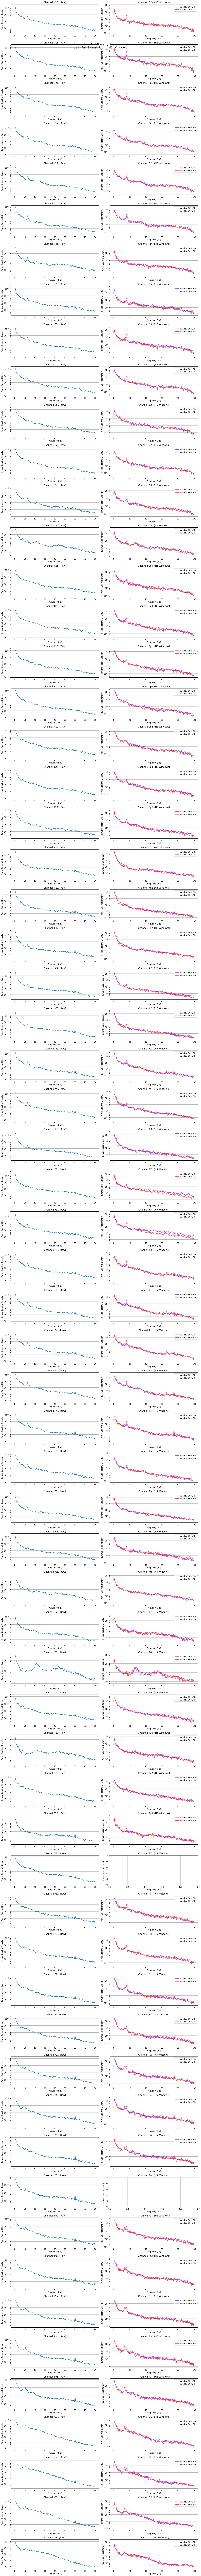


PSD Statistics:
--------------------------------------------------

Channel: Fc5.
Raw EDF - Mean Power: 3.48e-11, Peak Power: 2.19e-09 at 0.2 Hz

Channel: Fc3.
Raw EDF - Mean Power: 3.47e-11, Peak Power: 1.73e-09 at 0.2 Hz

Channel: Fc1.
Raw EDF - Mean Power: 3.60e-11, Peak Power: 1.71e-09 at 0.2 Hz

Channel: Fcz.
Raw EDF - Mean Power: 3.69e-11, Peak Power: 1.87e-09 at 0.2 Hz

Channel: Fc2.
Raw EDF - Mean Power: 3.29e-11, Peak Power: 1.42e-09 at 0.2 Hz

Channel: Fc4.
Raw EDF - Mean Power: 2.55e-11, Peak Power: 9.63e-10 at 0.5 Hz

Channel: Fc6.
Raw EDF - Mean Power: 1.86e-11, Peak Power: 6.18e-10 at 0.2 Hz

Channel: C5..
Raw EDF - Mean Power: 2.96e-11, Peak Power: 1.55e-09 at 0.2 Hz

Channel: C3..
Raw EDF - Mean Power: 3.26e-11, Peak Power: 1.49e-09 at 0.2 Hz

Channel: C1..
Raw EDF - Mean Power: 3.51e-11, Peak Power: 1.58e-09 at 0.2 Hz

Channel: Cz..
Raw EDF - Mean Power: 3.65e-11, Peak Power: 1.64e-09 at 0.2 Hz

Channel: C2..
Raw EDF - Mean Power: 3.27e-11, Peak Power: 1.43e-09 at 0.2

In [34]:
edf_path = "/content/drive/MyDrive/LiNC Lab/physionetMI/raw/S001/S001R04.edf"
h5_datasets = ['S001R04-0_eeg','S001R04-1_eeg']

plot_psd_comparison(edf_path, h5_file, h5_datasets)

# old visualization

Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB



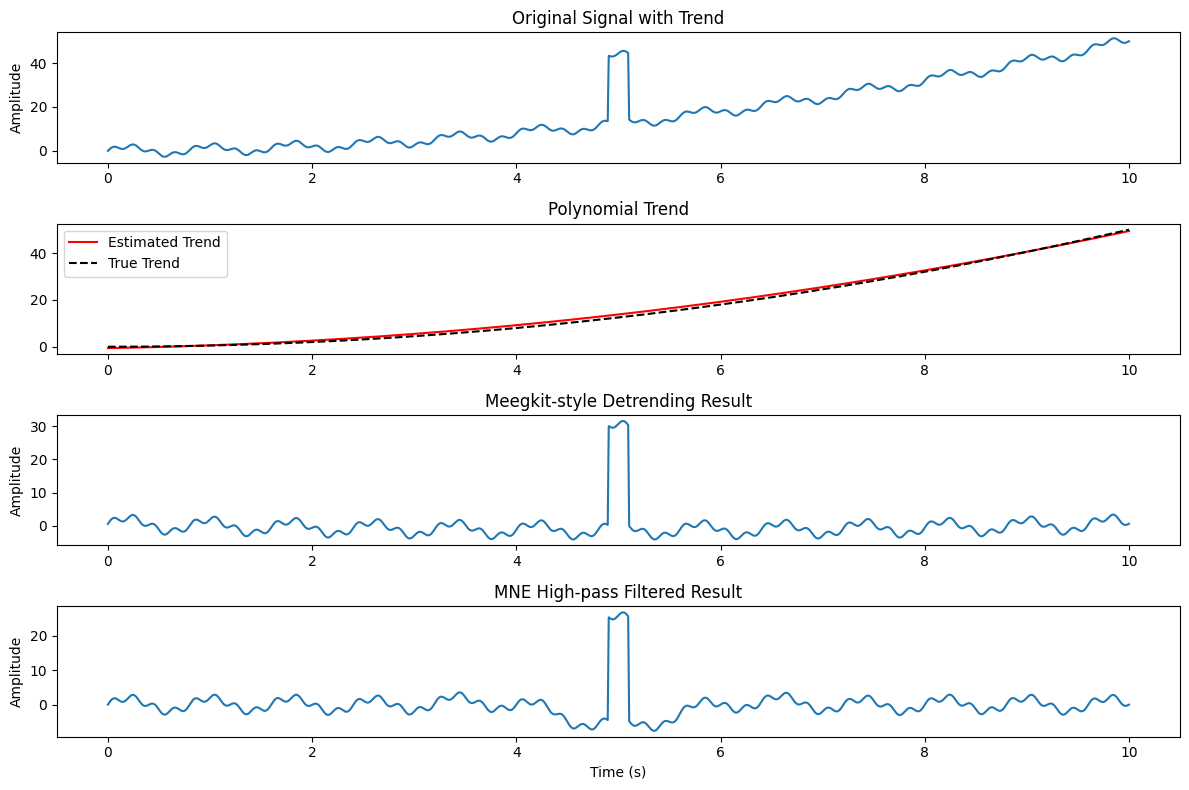

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data
import scipy.signal as signal




sfreq=200
# Generate sample data with trend
t = np.linspace(0, 10, 1000)
trend = 0.5 * t**2  # quadratic trend
# Add spike
spike_center = len(t) // 2
spike_width = int(0.05 * sfreq)  # 2 second width in samples
spike = np.zeros_like(t)
spike[spike_center-spike_width:spike_center+spike_width] = 30

signal_freq = 5
pure_signal = np.sin(2 * np.pi * signal_freq * t) + 2*np.sin(0.5 * np.pi * signal_freq * t)
noisy_signal = pure_signal + trend + spike

# Function to simulate meegkit-style detrending
def polynomial_detrend(x, order=2):
    t = np.arange(len(x))
    p = np.polynomial.polynomial.polyfit(t, x, order)
    trend = np.polynomial.polynomial.polyval(t, p)
    return x - trend, trend

# Apply both methods
# 1. Polynomial detrending (meegkit-style)
detrended_poly, estimated_trend = polynomial_detrend(noisy_signal, order=2)

# 2. MNE highpass filtering
sfreq = len(t) / t[-1]  # sampling frequency
highpass_freq = 0.5  # Hz
filtered_signal = filter_data(noisy_signal, sfreq=sfreq, l_freq=highpass_freq,
                            h_freq=None, method='iir')

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(t, noisy_signal)
plt.title('Original Signal with Trend')
plt.ylabel('Amplitude')

plt.subplot(412)
plt.plot(t, estimated_trend, 'r', label='Estimated Trend')
plt.plot(t, trend, 'k--', label='True Trend')
plt.title('Polynomial Trend')
plt.legend()

plt.subplot(413)
plt.plot(t, detrended_poly)
plt.title('Meegkit-style Detrending Result')
plt.ylabel('Amplitude')

plt.subplot(414)
plt.plot(t, filtered_signal)
plt.title('MNE High-pass Filtered Result')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()

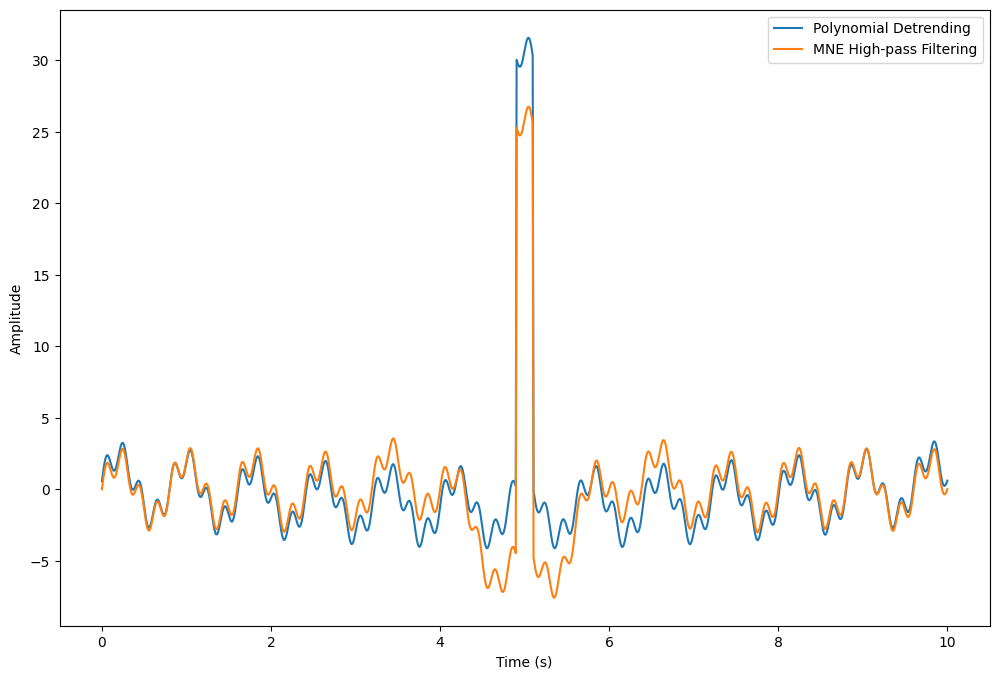

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(t, detrended_poly, label='Polynomial Detrending')
plt.plot(t, filtered_signal, label='MNE High-pass Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
# plt.xlim(3, 7)
plt.show()

In [ ]:
import os

In [ ]:
#test if get_row_from_SPEED works
pp = PostProcessingAndSaving(df_pretrain, SPEED_output_path, h5_save_path, save_method, h5_save_format)
row = pp.get_row_from_SPEED(fif_paths[0])
row


NameError: name 'PostProcessingAndSaving' is not defined

In [ ]:
df_pretrain['filename']

0        aaaaakee_s001_t000.edf
1        aaaaakfb_s001_t001.edf
2        aaaaakbs_s001_t001.edf
3        aaaaakbs_s001_t002.edf
4        aaaaakdt_s001_t001.edf
                  ...          
57925    aaaaarux_s003_t004.edf
57926    aaaaarux_s003_t007.edf
57927    aaaaarux_s003_t008.edf
57928    aaaaarux_s001_t000.edf
57929    aaaaaruo_s001_t000.edf
Name: filename, Length: 57930, dtype: object

In [ ]:
df_pretrain

filename  \
0      aaaaakee_s001_t000.edf   
1      aaaaakfb_s001_t001.edf   
2      aaaaakbs_s001_t001.edf   
3      aaaaakbs_s001_t002.edf   
4      aaaaakdt_s001_t001.edf   
...                       ...   
57925  aaaaarux_s003_t004.edf   
57926  aaaaarux_s003_t007.edf   
57927  aaaaarux_s003_t008.edf   
57928  aaaaarux_s001_t000.edf   
57929  aaaaaruo_s001_t000.edf   

                                               full_path source_dataset  \
0      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
1      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
2      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
3      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
4      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
...                                                  ...            ...   
57925  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57926  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57927  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57928  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57929  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   

         montage       sub  in_tuh_eeg  in_tuh_eeg_abnormal  \
0      02_tcp_le  aaaaakee        True                False   
1      01_tcp_ar  aaaaakfb        True                False   
2      02_tcp_le  aaaaakbs        True                False   
3      02_tcp_le  aaaaakbs        True                False   
4      01_tcp_ar  aaaaakdt        True                False   
...          ...       ...         ...                  ...   
57925  01_tcp_ar  aaaaarux        True                False   
57926  01_tcp_ar  aaaaarux        True                False   
57927  01_tcp_ar  aaaaarux        True                False   
57928  01_tcp_ar  aaaaarux        True                False   
57929  01_tcp_ar  aaaaaruo        True                False   

       in_tuh_eeg_artifact  in_tuh_eeg_epilepsy  in_tuh_eeg_events  \
0                    False                False              False   
1                    False                False              False   
2                    False                False              False   
3                    False                False              False   
4                    False                False              False   
...                    ...                  ...                ...   
57925                False                False              False   
57926                False                False              False   
57927                False                False              False   
57928                False                False              False   
57929                False                False              False   

       in_tuh_eeg_seizure  in_tuh_eeg_slowing  in_tuh_eeg_software  \
0                   False               False                False   
1                   False               False                False   
2                   False               False                False   
3                   False               False                False   
4                   False               False                False   
...                   ...                 ...                  ...   
57925               False               False                False   
57926               False               False                False   
57927               False               False                False   
57928               False               False                False   
57929               False               False                False   

       dataset_count  only_in_main  only_in_subdatasets  subs_only_in_main  
0                  1          True                False               True  
1                  1          True                False               True  
2                  1          True                Fal

In [ ]:
class PostProcessingAndSaving:
    def __init__(self, df_pretrain,  SPEED_output_path, h5_save_path,
                 save_method : str = 'tueg_fif_ours', h5_save_format : str = 'LaBraM'):
        self.df_pretrain = df_pretrain
        self.save_method = save_method
        self.SPEED_output_path = SPEED_output_path
        self.h5_save_path = h5_save_path
        self.h5_save_format = h5_save_format

        #setting some stuff up
        self.fif_paths = glob(os.path.join(SPEED_output_path, '**/*.fif'), recursive=True)


        #example of usage :
        #get_row_from_SPEED(fif_paths[0]) #get the corresponding row from df_pretrain for the fif_paths[0] file


    ###=====METHODS FOR GETTING LABELS (NOT USED FOR NOW, FOR ANGELA)=====###
    def get_row_from_SPEED(self, fif_path)  :
        #! this was added for future compatibility (df_pretrain is not needed tbh, but for the future when labeled data is needed, from which label should be brought from df_pretrain)
        if self.save_method == 'tueg_fif_ours':
            return self._tueg_fif_ours_mapper(fif_path)
        else:
            raise ValueError("save_method not recognized")

    def _tueg_fif_ours_mapper(self, fif_path):
        r"""
        maps the fif file to the pretrain dataframe assuming "tueg_fif_ours" method was used for `save_method` in SPEED yaml
        """
        #get the subject id
        folder_name = fif_path.split('/')[-2]
        window_dix = fif_path.split('/')[-1].split('.')[0]

        #get the pretrain dataframe row
        pretrain_row = self.df_pretrain[self.df_pretrain['filename'] == folder_name + '.edf']
        return pretrain_row

      ###=====METHODS FOR POSTPROCESSING=====###
    def adhoc_clip_data(self, **):
        raise NotImplementedError("Not implemented yet")


    def normalize_data(self, method : str, units : Optional[str] = None):
        r"""
        method :
            * None : no normalization
            * 'ch_zscore' : zscore normalization (channel-wise)
            * 'ch_minmax' : minmax normalization (channel-wise)
            * 'units' : normalize to units (channel-wise) (ex : units = 'uV')
            * 'laura' : Laura's method => #! should be implemetned
        """
        raise NotImplementedError("Not implemented yet")
        if method is None :
            return
        elif method == 'ch_zscore' :
            self.raw = self.raw.apply_function(lambda x : (x - np.mean(x)) / np.std(x))
        elif method == 'ch_minmax' :
            self.raw = self.raw.apply_function(lambda x : (x - np.min(x)) / (np.max(x) - np.min(x)))
        elif method == 'units' :
            #uV 하기! (if specified)
            raise NotImplementedError("Not implemented yet")
            # assert units is not None
            # self.raw = self.raw.apply_function(lambda x : x * units)

    ###=====METHODS FOR SAVING=====###





SyntaxError: invalid syntax (<ipython-input-14-18478f422ecc>, line 39)

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt


# Load the data
raw = mne.io.read_raw_edf('/global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_TUEG_small_data/aaaaaaau/s001_2006/02_tcp_le/aaaaaaau_s001_t000.edf', preload = True)

raw.info

Extracting EDF parameters from /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_TUEG_small_data/aaaaaaau/s001_2006/02_tcp_le/aaaaaaau_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-LE, EEG FP2-LE, EEG F3-LE, EEG F4-LE, EEG C3-LE, EEG ...
 chs: 41 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2006-01-01 00:00:00 UTC
 nchan: 41
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

In [ ]:
df_pretrain

filename  \
0      aaaaakee_s001_t000.edf   
1      aaaaakfb_s001_t001.edf   
2      aaaaakbs_s001_t001.edf   
3      aaaaakbs_s001_t002.edf   
4      aaaaakdt_s001_t001.edf   
...                       ...   
57925  aaaaarux_s003_t004.edf   
57926  aaaaarux_s003_t007.edf   
57927  aaaaarux_s003_t008.edf   
57928  aaaaarux_s001_t000.edf   
57929  aaaaaruo_s001_t000.edf   

                                               full_path source_dataset  \
0      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
1      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
2      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
3      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
4      /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
...                                                  ...            ...   
57925  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57926  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57927  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57928  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   
57929  /global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...        tuh_eeg   

         montage       sub  in_tuh_eeg  in_tuh_eeg_abnormal  \
0      02_tcp_le  aaaaakee        True                False   
1      01_tcp_ar  aaaaakfb        True                False   
2      02_tcp_le  aaaaakbs        True                False   
3      02_tcp_le  aaaaakbs        True                False   
4      01_tcp_ar  aaaaakdt        True                False   
...          ...       ...         ...                  ...   
57925  01_tcp_ar  aaaaarux        True                False   
57926  01_tcp_ar  aaaaarux        True                False   
57927  01_tcp_ar  aaaaarux        True                False   
57928  01_tcp_ar  aaaaarux        True                False   
57929  01_tcp_ar  aaaaaruo        True                False   

       in_tuh_eeg_artifact  in_tuh_eeg_epilepsy  in_tuh_eeg_events  \
0                    False                False              False   
1                    False                False              False   
2                    False                False              False   
3                    False                False              False   
4                    False                False              False   
...                    ...                  ...                ...   
57925                False                False              False   
57926                False                False              False   
57927                False                False              False   
57928                False                False              False   
57929                False                False              False   

       in_tuh_eeg_seizure  in_tuh_eeg_slowing  in_tuh_eeg_software  \
0                   False               False                False   
1                   False               False                False   
2                   False               False                False   
3                   False               False                False   
4                   False               False                False   
...                   ...                 ...                  ...   
57925               False               False                False   
57926               False               False                False   
57927               False               False                False   
57928               False               False                False   
57929               False               False                False   

       dataset_count  only_in_main  only_in_subdatasets  subs_only_in_main  
0                  1          True                False               True  
1                  1          True                False               True  
2                  1          True                Fal

In [ ]:
df_pretrain.iloc[0]["full_path"]

'/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/tuh_eeg/v2.0.1/edf/068/aaaaakee/s001_2010/02_tcp_le/aaaaakee_s001_t000.edf'

In [ ]:
import pyprep
noisychannels = pyprep.NoisyChannels(data)
noisychannels.find_bad_by_SNR()
noisychannels.find_bad_by_correlation()
noisychannels.find_bad_by_deviation()
noisychannels.find_bad_by_hfnoise()
noisychannels.find_bad_by_nan_flat()


noisychannels.get_bads()

ModuleNotFoundError: No module named 'pyprep'